In [1]:
%pip install imutils
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2
import argparse
import ntpath
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import imutils
from imutils.video import WebcamVideoStream
from imutils import face_utils
from Detect_Acne import *
import math

import time

In [3]:
# to detect face feature
import dlib
predictor_model = 'shape_predictor_68_face_landmarks.dat'
detector = dlib.get_frontal_face_detector()# dlib人脸检测器
predictor = dlib.shape_predictor(predictor_model)


In [4]:
def readFiles(path):
    img = cv2.imread(path)
    return img

In [5]:
# detectors = {
#     "eye": os.path.sep.join([ntpath.dirname(cv2.__file__), 'data', 'haarcascade_eye.xml']),
#     "face": os.path.sep.join([ntpath.dirname(cv2.__file__), 'data', 'haarcascade_frontalface_default.xml'])
# }
# def detect(gray, part="face"):
    
#     detector = cv2.CascadeClassifier(detectors[part])
#     rects = detector.detectMultiScale(gray, scaleFactor=2, minNeighbors=5, minSize=(15, 15),
#                                       flags=cv2.CASCADE_SCALE_IMAGE)
#     return rects

In [6]:
def img2Gray(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img, gray

In [7]:
def showImage(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [8]:
def GetFaceMask(img):
    img, Gimg = img2Gray(img)
    rects = detect(Gimg) # return multi-face
    
    # Face mask, cut out of face region
    Facemask = np.zeros_like(img)
    (y, x, w, h) = rects[0].astype("int")
    Facemask = cv2.rectangle(Facemask, (y,x), (y + w, x + h), (255,255,255), -1)
    
    return Facemask

In [9]:
def skinDetection(img):
    img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    HSV_mask = cv2.inRange(img_HSV, (0, 15, 0), (17,170,255)) 
    HSV_mask = cv2.morphologyEx(HSV_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))

    #converting from gbr to YCbCr color space
    img_YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    #skin color range for hsv color space 
    YCrCb_mask = cv2.inRange(img_YCrCb, (0, 135, 85), (255,180,135)) 
    YCrCb_mask = cv2.morphologyEx(YCrCb_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))

    #merge skin detection (YCbCr and hsv)
    global_mask=cv2.bitwise_and(YCrCb_mask,HSV_mask)
    global_mask=cv2.medianBlur(global_mask,3)
    global_mask = cv2.morphologyEx(global_mask, cv2.MORPH_OPEN, np.ones((4,4), np.uint8))


    HSV_result = cv2.bitwise_not(HSV_mask)
    YCrCb_result = cv2.bitwise_not(YCrCb_mask)
    global_result=cv2.bitwise_not(global_mask)
    
    return global_result

In [10]:
def GetSkinMask(img):
    # find skin region, 0 is skin, otherwise is 1
    SkinImage = skinDetection(img)
    skinMask = np.zeros_like(img)
    skinMask[SkinImage[:,:] == 0] = (255,255,255)
    skinMask[SkinImage[:,:] == 1] = (0, 0, 0)
    
    return skinMask


In [121]:

def getForeHead(landsmark):
    forehead = np.zeros([5,2], dtype = np.int)
    int_lmrks = np.array(landsmark, dtype=np.int)
    D_nose = abs(int_lmrks[27]-int_lmrks[30])
    print("D_nose : " + str(D_nose))
    L_eye = abs(int_lmrks[36][0] - int_lmrks[40][0])
    R_eye = abs(int_lmrks[42][0] - int_lmrks[45][0]) 
    
    leftEye = ((int_lmrks[36] + int_lmrks[39]) / 2)
    rightEye = ((int_lmrks[42] + int_lmrks[45]) / 2)
    centroidEye = ( (leftEye+rightEye) / 2)
    lineX = leftEye[0] - rightEye[0]
    lineY = leftEye[1] - rightEye[1]
    mag =  math.sqrt((lineX*lineX) + (lineY*lineY))
    
    lineX = lineX/mag
    lineY = lineY/mag
    
    VlineY = lineX
    VlineX = -lineY
    
    # diff from centroidEye to noise
    diff = (centroidEye - int_lmrks[30])
    length = math.sqrt((diff[0]*diff[0]+diff[1]*diff[1]))
    
    # diff from centroidEye to leftEye
    diffL = (centroidEye - int_lmrks[16])
    print("diffL" + str(diffL))
    lengthL = math.sqrt((diffL[0]*diffL[0]+diffL[1]*diffL[1]))

    # diff from centroidEye to rightEye
    diffR = (centroidEye - int_lmrks[0])
    print("diffR" + str(diffR))
    lengthR = math.sqrt((diffR[0]*diffR[0]+diffR[1]*diffR[1]))

    
    # normalize C

#     print("test")
#     print(int_lmrks[5][0])
#     print(int_lmrks[17])
#     print(int_lmrks[11])
#     print(int_lmrks[26])
#     print("test")
    C = 1
    # a 
    forehead[0] =  int_lmrks[0]

    # b
    forehead[1][0] =  round(centroidEye[0] + 2*length * VlineX + 0.8*lengthR * lineX)
    forehead[1][1] =  round(centroidEye[1] + 2*length * VlineY + 0.8*lengthR * lineY)
    print("lengthR : " + str(lengthR))
    
    # c
    forehead[2] =  int_lmrks[16]
    
    # d
    forehead[3][0] =  round(centroidEye[0] + 2*length * VlineX - 0.8*lengthL * lineX)
    forehead[3][1] =  round(centroidEye[1] + 2*length * VlineY - 0.8*lengthL * lineY)
    print("lengthL : " + str(lengthL))
    
    # e
    forehead[4][0] =  round(centroidEye[0] + 2.5*length * VlineX)
    forehead[4][1] =  round(centroidEye[1] + 2.5*length * VlineY)
    
    return forehead

1.5441820621490479
D_nose : [  3 117]
diffL[-193.75   33.  ]
diffR[186.25  43.  ]
lengthR : 191.14931990462324
lengthL : 196.54023125049997
(5, 2)
[192 292]
[232 103]
[572 302]
[542 111]
[386  50]


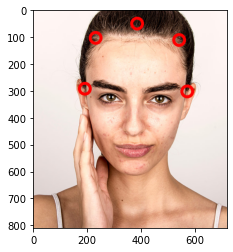

In [125]:
Origin_img = cv2.imread('data/t4.jpg')
img, Gimg = img2Gray(Origin_img)
face, landmarks = get_landmarks(Gimg)
result = getForeHead(landmarks)
print(result.shape)
for points in result:
    print(points)
    cv2.circle(img, (points[0], points[1]), 20, (0, 0, 255), 10)
    
int_lmrks = np.array(landmarks, dtype=np.int)
showImage(img)

In [126]:
def get_landmarks(Gimg):

    detector = dlib.get_frontal_face_detector()
    
    StartTime = time.time() # start time
    predictor = dlib.shape_predictor(predictor_model)
    
    print(time.time() - StartTime) # end time
    
    rects = detector(Gimg, 0)
    face = rects[0]
    
    shape = predictor(Gimg, face)
    shape = face_utils.shape_to_np(shape)

    
    landmarks = np.matrix([[p.x, p.y] for p in predictor(Gimg, face).parts()])
    for points in predictor(Gimg, face).parts():
        cv2.circle(Gimg, (points.x, points.y), 1, (0, 0, 255), 10)

    
    return face, landmarks


In [127]:
%pip install pyclipper
import pyclipper

def perimeter(poly):
    p = 0
    nums = poly.shape[0]
    for i in range(nums):
        p += abs(np.linalg.norm(poly[i % nums] - poly[(i + 1) % nums]))
    return p

def proportional_zoom_contour(contour, ratio):
    """
    多边形轮廓点按照比例进行缩放
    :param contour: 一个图形的轮廓格式[[[x1, x2]],...],shape是(-1, 1, 2)
    :param ratio: 缩放的比例，如果大于1是放大小于1是缩小
    :return:
    """
    poly = contour[:, :]
    area_poly = abs(pyclipper.Area(poly))
    perimeter_poly = perimeter(poly)
    poly_s = []
    pco = pyclipper.PyclipperOffset()
    pco.MiterLimit = 10
    if perimeter_poly:
        d = area_poly * (1 - ratio * ratio) / perimeter_poly
        pco.AddPath(poly, pyclipper.JT_MITER, pyclipper.ET_CLOSEDPOLYGON)
        poly_s = pco.Execute(-d)
    poly_s = np.array(poly_s).reshape(-1, 1, 2).astype(int)

    return poly_s

def get_image_hull_mask(img, image_landmarks, ie_polys=None):
    # get the mask of the image
#     if image_landmarks.shape[0] != 68:
#         raise Exception(
#             'get_image_hull_mask works only with 68 landmarks')



    
    
    int_lmrks = np.array(image_landmarks, dtype=np.int)
    #hull_mask = np.zeros(image_shape[0:2]+(1,), dtype=np.float32)
    hull_mask = np.zeros_like(img)

    
    forehead = getForeHead(image_landmarks)
    cv2.fillConvexPoly(
        hull_mask, cv2.convexHull(forehead), (255,255,255))
    
    
    cv2.fillConvexPoly(hull_mask, cv2.convexHull(
        np.concatenate((int_lmrks[0:9],
                        int_lmrks[17:18]))), (255,255, 255))

    cv2.fillConvexPoly(hull_mask, cv2.convexHull(
        np.concatenate((int_lmrks[8:17],
                        int_lmrks[26:27]))), (255,255, 255))

    cv2.fillConvexPoly(hull_mask, cv2.convexHull(
        np.concatenate((int_lmrks[17:20],
                        int_lmrks[8:9]))), (255,255, 255))

    cv2.fillConvexPoly(hull_mask, cv2.convexHull(
        np.concatenate((int_lmrks[24:27],
                        int_lmrks[8:9]))), (255,255, 255))

    cv2.fillConvexPoly(hull_mask, cv2.convexHull(
        np.concatenate((int_lmrks[19:25],
                        int_lmrks[8:9],
                        ))), (255,255, 255))

    cv2.fillConvexPoly(hull_mask, cv2.convexHull(
        np.concatenate((int_lmrks[17:22],
                        int_lmrks[27:28],
                        int_lmrks[31:36],
                        int_lmrks[8:9]
                        ))), (255,255, 255))

    cv2.fillConvexPoly(hull_mask, cv2.convexHull(
        np.concatenate((int_lmrks[22:27],
                        int_lmrks[27:28],
                        int_lmrks[31:36],
                        int_lmrks[8:9]
                        ))), (255,255, 255))
#     cv2.fillConvexPoly(hull_mask, cv2.convexHull(
#                         int_lmrks[68:81]), (255,255, 255))

    nose = proportional_zoom_contour(int_lmrks[27:36], 1.2)
    l_eyes = proportional_zoom_contour(int_lmrks[36:42], 1.8)
    r_eyes = proportional_zoom_contour(int_lmrks[42:48], 1.8)
    mouse = proportional_zoom_contour(int_lmrks[48:60], 1.3)
    
    l_brow = proportional_zoom_contour(int_lmrks[17:22], 1.4)
    r_brow = proportional_zoom_contour(int_lmrks[22:27], 1.4)
    
    
    #face
    for i in range(17-3):
        cv2.fillConvexPoly(
            hull_mask, int_lmrks[i:i+3], (0,0, 0))
        
    # nose
    cv2.fillConvexPoly(
        hull_mask, cv2.convexHull(nose), (0,0, 0))
    # left eyes
    cv2.fillConvexPoly(
        hull_mask, cv2.convexHull(l_eyes), (0,0, 0))
    # right eyes
    cv2.fillConvexPoly(
        hull_mask, cv2.convexHull(r_eyes), (0,0, 0))
    # mouse 
    cv2.fillConvexPoly(
        hull_mask, cv2.convexHull(mouse), (0,0, 0))
    
    #brow
    cv2.fillConvexPoly(
        hull_mask, cv2.convexHull(l_brow), (0,0, 0))
    cv2.fillConvexPoly(
        hull_mask, cv2.convexHull(r_brow), (0,0, 0))
    

    

    return hull_mask

Note: you may need to restart the kernel to use updated packages.


1.603748083114624
D_nose : [11 71]
diffL[-147.25    9.25]
diffR[149.75 -12.75]
lengthR : 150.2917995101529
lengthL : 147.54024874589305


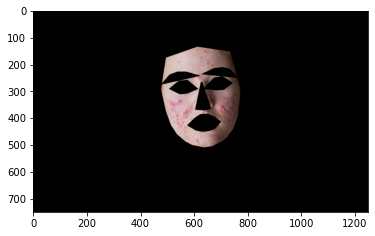

In [128]:
if __name__ == "__main__":
    
    #Read Image
    Origin_img = cv2.imread('data/t3.jpg')
#     Origin_img = imutils.resize(Origin_img, width=600)
    img = Origin_img.copy()
    
    img,Gimg = img2Gray(img)
    
#     # Method 1 to get face (Skin Detection and Face Detection(Harr))
#     skinMask = GetSkinMask(img)
#     faceMask = GetFaceMask(img)
#     # combine two mask
#     Face_Skin_Mask = cv2.bitwise_and(skinMask, faceMask)
#     img = cv2.bitwise_and(Face_Skin_Mask, img)
#     # can't cut out only face in result

    # Method 2 to get face (Use Dlib)
    SkinMask = GetSkinMask(img)
    face, landmarks = get_landmarks(Gimg)
    faceMask = get_image_hull_mask(img, landmarks)
    img = cv2.bitwise_and(faceMask, img)
    cv2.imwrite("faceMask.jpg", img)
    showImage(img)
#     img = cv2.bitwise_and(SkinMask, img)
    # not a good method, which cost 1.55 sec

    
#     img = cv2.imread('./data/acne.jpg')
    ad = Acne_Dector(img)
    ad.run(method =1, debug=False)
    img = cv2.inpaint(Origin_img, ad.mask, 3, cv2.INPAINT_TELEA)

    cv2.imwrite("Result_acne_face.jpg", img)
    cv2.imwrite("Mask2.jpg", ad.mask)
    

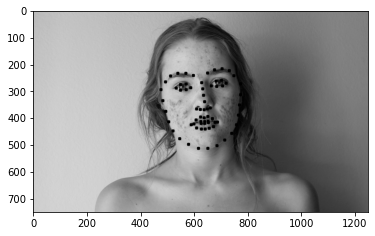

In [129]:
showImage(Gimg)

In [130]:
heightResize = 480
framesSkipping = 1

cameraObject = cv2.VideoCapture(0)
ret, image = cameraObject.read()
height = image.shape[0]

frame_resize_scale = float(height)/heightResize
modelPath = "shape_predictor_81_face_landmarks.dat"

faceDetector = dlib.get_frontal_face_detector()
shapePredictor = dlib.shape_predictor(modelPath)


def Recording():
    count = 0
    # open webcam
    vs = WebcamVideoStream().start()
    start = time.time()
    fps = vs.stream.get(cv2.CAP_PROP_FPS)
    print("Frames per second using cv2.CAP_PROP_FPS : {0}".format(fps))

    while True:
        # turn to gray image to detect face
        frame = vs.read()
        img = frame.copy()
        img = imutils.resize(img, width=600)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        
        if (count % framesSkipping == 0):
            faces = faceDetector(img,0)
        for face in faces:
#             newRectValues = dlib.rectangle(int(face.left() * frame_resize_scale),
#                                int(face.top() * frame_resize_scale),
#                                int(face.right() * frame_resize_scale),
#                                int(face.bottom() * frame_resize_scale))
            predictor = shapePredictor(img, face)
            landmarks = np.matrix([[p.x, p.y] for p in predictor.parts()])
            try:
                faceMask = get_image_hull_mask(img, landmarks)
            except:
                pass
        img = cv2.bitwise_and(faceMask, img)
        cv2.imshow("Frame", img)

        count = count + 1
        # calculate framePerSecond at an interval of 100 frames
        if (count == 100):
            count = 0
        
        # 判斷是否案下"q"；跳離迴圈
        key = cv2.waitKey(1) & 0xff
        if key == ord('q'):
            break

    #  清除畫面與結束WebCam
    cv2.destroyAllWindows()
    vs.stop()


Recording()

Frames per second using cv2.CAP_PROP_FPS : nan
D_nose : [ 0 34]
diffL[-70.25   0.5 ]
diffR[69.75  0.5 ]
lengthR : 69.75179209167317
lengthL : 70.25177933689652
D_nose : [ 0 34]
diffL[-71.5   0.5]
diffR[69.5  1.5]
lengthR : 69.51618516575834
lengthL : 71.50174823037545
D_nose : [ 0 34]
diffL[-71.    -0.25]
diffR[69.    0.75]
lengthR : 69.00407596656882
lengthL : 71.00044013948083
D_nose : [ 0 34]
diffL[-71.25  -0.25]
diffR[68.75  0.75]
lengthR : 68.75409078738515
lengthL : 71.25043859514129
D_nose : [ 1 35]
diffL[-74.25  -3.  ]
diffR[70.75 -5.  ]
lengthR : 70.92645839177366
lengthL : 74.31058134613131
D_nose : [ 0 34]
diffL[-70.5  -0.5]
diffR[69.5  0.5]
lengthR : 69.50179853787958
lengthL : 70.50177302735017
D_nose : [ 0 35]
diffL[-71.75  -0.25]
diffR[69.25  0.75]
lengthR : 69.25406125275254
lengthL : 71.75043553874778
D_nose : [ 0 34]
diffL[-71.5   -1.25]
diffR[69.5   0.75]
lengthR : 69.50404664478177
lengthL : 71.51092573865898
D_nose : [ 0 34]
diffL[-71.5   0. ]
diffR[69.5  1. ]
leng

D_nose : [ 5 31]
diffL[-43.   -12.25]
diffR[93.    5.75]
lengthR : 93.17758582405963
lengthL : 44.710876752754466
D_nose : [ 6 31]
diffL[-43.25 -12.  ]
diffR[92.75  5.  ]
lengthR : 92.88467311672039
lengthL : 44.883877951888245
D_nose : [ 5 32]
diffL[-43.5 -12. ]
diffR[91.5  5. ]
lengthR : 91.6365101910805
lengthL : 45.12482686947397
D_nose : [ 5 32]
diffL[-44.5 -11.5]
diffR[91.5  5.5]
lengthR : 91.6651515026294
lengthL : 45.96194077712559
D_nose : [ 6 32]
diffL[-43.25 -12.  ]
diffR[91.75  4.  ]
lengthR : 91.83715206821257
lengthL : 44.883877951888245
D_nose : [ 5 32]
diffL[-45.   -10.75]
diffR[92.    3.25]
lengthR : 92.05738699311425
lengthL : 46.26621337434046
D_nose : [ 4 31]
diffL[-47.  -10.5]
diffR[89.   4.5]
lengthR : 89.11369142842193
lengthL : 48.158592172114
D_nose : [ 4 32]
diffL[-52.75  -7.75]
diffR[84.25  3.25]
lengthR : 84.3126621569975
lengthL : 53.31627331312645
D_nose : [ 3 33]
diffL[-57.75  -6.  ]
diffR[81.25  2.  ]
lengthR : 81.27461165702363
lengthL : 58.060851698885

/var/folders/fl/0gvtd2b94r578g4v1cqx9vn40000gn/T/ipykernel_33855/4217149736.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  poly_s = np.array(poly_s).reshape(-1, 1, 2).astype(int)


D_nose : [10 30]
diffL[-35.  -5.]
diffR[96.  3.]
lengthR : 96.04686356149273
lengthL : 35.35533905932738
D_nose : [10 30]
diffL[-35.75  -7.5 ]
diffR[95.25  2.5 ]
lengthR : 95.28280275054885
lengthL : 36.52824249810001
D_nose : [10 30]
diffL[-35.    -6.25]
diffR[95.    2.75]
lengthR : 95.03979429691543
lengthL : 35.55365663331973
D_nose : [11 30]
diffL[-35.   -6.5]
diffR[95.   1.5]
lengthR : 95.01184136727379
lengthL : 35.59845502265512
D_nose : [11 30]
diffL[-35.25  -7.  ]
diffR[94.75  2.  ]
lengthR : 94.7711058287282
lengthL : 35.93831520814519
D_nose : [10 29]
diffL[-33.25  -9.25]
diffR[94.75  1.75]
lengthR : 94.76615957186405
lengthL : 34.5126788296707
D_nose : [10 30]
diffL[-36.5  -8.5]
diffR[95.5  0.5]
lengthR : 95.50130889155395
lengthL : 37.476659402887016
D_nose : [ 9 30]
diffL[-36.25  -8.5 ]
diffR[94.75  2.5 ]
lengthR : 94.78297579206932
lengthL : 37.233217696030515
D_nose : [ 9 29]
diffL[-36.   -8.5]
diffR[95.   1.5]
lengthR : 95.01184136727379
lengthL : 36.98986347636336
D_n

D_nose : [ 4 27]
diffL[-69.25  -7.5 ]
diffR[59.75 -0.5 ]
lengthR : 59.7520920135856
lengthL : 69.65495316199703
D_nose : [ 2 28]
diffL[-68.75  -6.25]
diffR[60.25 -0.25]
lengthR : 60.25051866996665
lengthL : 69.03350635742038
D_nose : [ 3 30]
diffL[-68.25  -4.75]
diffR[61.75  1.25]
lengthR : 61.76265052602584
lengthL : 68.41509336396464
D_nose : [ 2 31]
diffL[-69.  -6.]
diffR[61.  0.]
lengthR : 61.0
lengthL : 69.26037828369117
D_nose : [ 2 32]
diffL[-69.5   -4.25]
diffR[63.5   1.75]
lengthR : 63.524109596278485
lengthL : 69.62982478794558
D_nose : [ 2 33]
diffL[-68.25  -3.5 ]
diffR[63.75  2.5 ]
lengthR : 63.79900077587423
lengthL : 68.33968466418322
D_nose : [ 2 34]
diffL[-70.   -3.5]
diffR[65.   2.5]
lengthR : 65.04805915628843
lengthL : 70.08744538075275
D_nose : [ 1 35]
diffL[-68.    -3.75]
diffR[67.    3.25]
lengthR : 67.07877831326388
lengthL : 68.10332223908023
D_nose : [ 1 35]
diffL[-67.5   -1.25]
diffR[67.5   5.75]
lengthR : 67.74446471852885
lengthL : 67.51157308195388
D_nose :

D_nose : [ 8 28]
diffL[-90.     6.25]
diffR[ 29.   -12.75]
lengthR : 31.6790545944793
lengthL : 90.21675287883066
D_nose : [ 8 28]
diffL[-91.75   6.25]
diffR[ 28.25 -12.75]
lengthR : 30.993951022739903
lengthL : 91.96262827910041
D_nose : [ 7 28]
diffL[-92.25   7.  ]
diffR[ 28.75 -13.  ]
lengthR : 31.552535555799633
lengthL : 92.51520145359896
D_nose : [ 8 28]
diffL[-91.5   7. ]
diffR[ 28.5 -12. ]
lengthR : 30.923292192132454
lengthL : 91.76736892817621
D_nose : [ 8 28]
diffL[-91.     6.75]
diffR[ 29.   -12.25]
lengthR : 31.481145150708862
lengthL : 91.25
D_nose : [ 9 29]
diffL[-91.25   6.25]
diffR[ 28.75 -10.75]
lengthR : 30.694054798934598
lengthL : 91.46379064963358
D_nose : [ 9 30]
diffL[-92.75   6.25]
diffR[31.25 -8.75]
lengthR : 32.45188746436792
lengthL : 92.96034100625923
D_nose : [ 8 31]
diffL[-92.75   6.25]
diffR[30.25 -9.75]
lengthR : 31.782463718220463
lengthL : 92.96034100625923
D_nose : [ 9 31]
diffL[-92.75   5.5 ]
diffR[30.25 -9.5 ]
lengthR : 31.706663337538373
lengthL :

D_nose : [ 4 28]
diffL[-59.   -4.5]
diffR[76.  -5.5]
lengthR : 76.19875327064085
lengthL : 59.17136131609615
D_nose : [ 3 28]
diffL[-62.5  -2. ]
diffR[73.5 -5. ]
lengthR : 73.66987172514962
lengthL : 62.53199181219162
D_nose : [ 2 28]
diffL[-65.25  -1.75]
diffR[69.75 -4.75]
lengthR : 69.9115512630066
lengthL : 65.27346321438752
D_nose : [ 2 29]
diffL[-68.25   0.25]
diffR[67.75 -6.75]
lengthR : 68.0854242844972
lengthL : 68.25045787392199
D_nose : [ 1 29]
diffL[-71.25   1.  ]
diffR[63.75 -7.  ]
lengthR : 64.13316224855905
lengthL : 71.25701719830826
D_nose : [ 1 29]
diffL[-74.25   4.25]
diffR[59.75 -8.75]
lengthR : 60.387291709431715
lengthL : 74.37153353266288
D_nose : [ 0 29]
diffL[-75.     5.75]
diffR[58.   -9.25]
lengthR : 58.732976256954665
lengthL : 75.22009372501472
D_nose : [ 0 28]
diffL[-76.75   5.5 ]
diffR[ 57.25 -10.5 ]
lengthR : 58.20491817707504
lengthL : 76.94681604848897
D_nose : [ 0 28]
diffL[-77.     6.75]
diffR[ 57.   -10.25]
lengthR : 57.914268535482684
lengthL : 77.2

In [44]:
n = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
n.reshape(-1,2,3)

array([[[ 1,  2,  3],
        [ 4,  5,  6]],

       [[ 7,  8,  9],
        [10, 11, 12]]])